In [86]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix


data = pd.read_csv(f'avax.csv')
df = df.drop(['Date'], 1)
df

/var/folders/_p/sv9gfrn10rx85mdybn7tz80m0000gn/T/ipykernel_80846/3072846978.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['Date'], 1)


,Price,Volume,CirSupply,Velocity,Valuation,Anomaly
0,4.57,21046683,24500000,0.86,3.37,1
1,4.71,11852948,24500001,0.48,1.10,0
2,4.54,6015212,24499998,0.25,0.27,0
3,4.63,5024973,24499998,0.21,0.19,0
4,4.20,4904941,24500001,0.20,0.17,0
...,...,...,...,...,...,...
690,27.93,17722721,284943340,0.06,0.11,0
691,27.16,15285795,284944436,0.05,0.08,0
692,25.49,19770085,284956454,0.07,0.12,0
693,24.26,16098307,284960662,0.06,0.08,0


In [87]:
df['Anomaly'] = np.where((df.Valuation>2), 1, 0) 
df.head()

,Price,Volume,CirSupply,Velocity,Valuation,Anomaly
0,4.57,21046683,24500000,0.86,3.37,1
1,4.71,11852948,24500001,0.48,1.10,0
2,4.54,6015212,24499998,0.25,0.27,0
3,4.63,5024973,24499998,0.21,0.19,0
4,4.20,4904941,24500001,0.20,0.17,0


In [88]:
# create histograms on all features
df_base = df.drop(['Date', 'Anomaly'], 1)
df_base.hist(figsize=(20,20), bins = 50)
plt.show()

/var/folders/_p/sv9gfrn10rx85mdybn7tz80m0000gn/T/ipykernel_80846/3646358145.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_base = df.drop(['Date', 'Anomaly'], 1)


KeyError: "['Date'] not found in axis"

<AxesSubplot:>

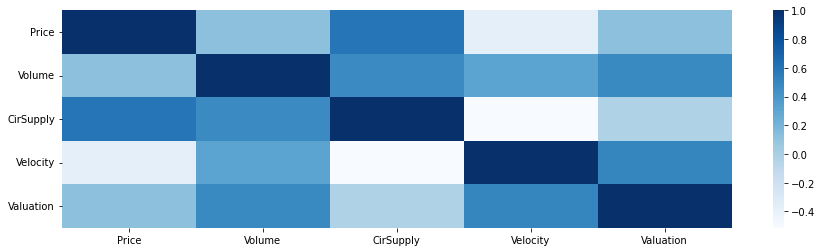

In [89]:
# Check that features are uncorrelated
plt.figure(figsize=(15,4))
f_cor = df_base.corr()
sns.heatmap(f_cor, cmap="Blues")

In [90]:
df_base

,Price,Volume,CirSupply,Velocity,Valuation
0,4.57,21046683,24500000,0.86,3.37
1,4.71,11852948,24500001,0.48,1.10
2,4.54,6015212,24499998,0.25,0.27
3,4.63,5024973,24499998,0.21,0.19
4,4.20,4904941,24500001,0.20,0.17
...,...,...,...,...,...
690,27.93,17722721,284943340,0.06,0.11
691,27.16,15285795,284944436,0.05,0.08
692,25.49,19770085,284956454,0.07,0.12
693,24.26,16098307,284960662,0.06,0.08


([<matplotlib.patches.Wedge at 0x7f95d3ad2550>,
 [Text(-0.8319902016413789, -0.7195778653993866, '0'),
  Text(0.9076256653308119, 0.7849940456034052, '1')],
 [Text(-0.4538128372589339, -0.3924970174905745, '97.70%'),
  Text(0.529448304776307, 0.457913193268653, '2.30%')])

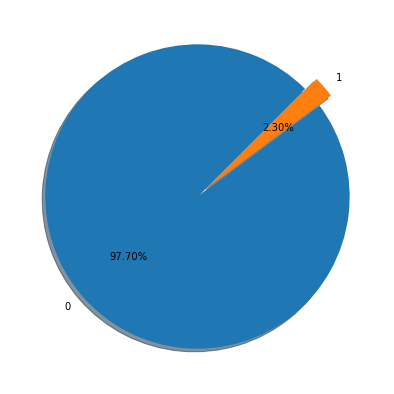

In [91]:
# Plot the balance of class labels
fig1, ax1 = plt.subplots(figsize=(14, 7))
plt.pie(df[['Anomaly']].value_counts(), explode=[0,0.1], labels=[0,1], autopct='%1.2f%%', shadow=True, startangle=45)

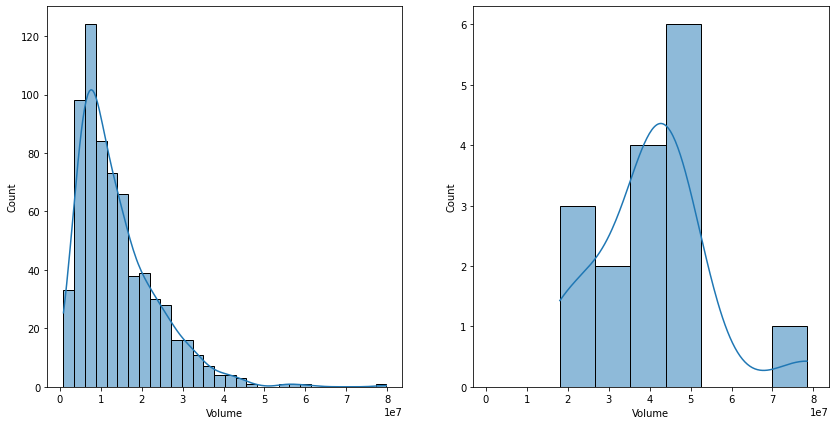

In [92]:
# Plot istribution of the Time variable, which contains transaction data for two days
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
sns.histplot(data=df[df['Anomaly'] == 0], x='Volume', kde=True, ax=ax[0])
sns.histplot(data=df[df['Anomaly'] == 1], x='Volume', kde=True, ax=ax[1])
plt.show()

Text(0.5, 0.98, 'AVAX')

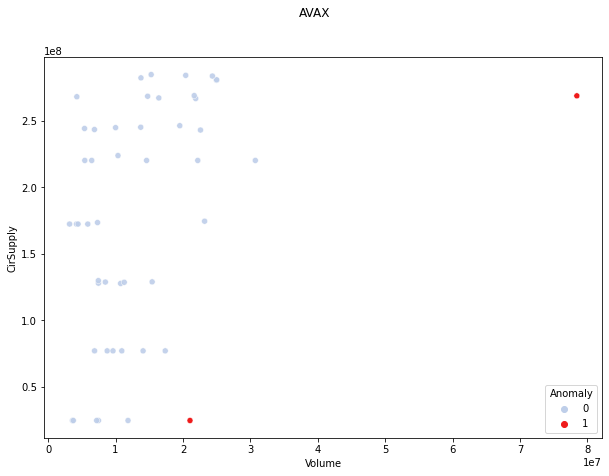

In [93]:
# Plot Volume against amount
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=df[df['Anomaly']==0][::15], x='Volume', y='CirSupply', hue="Anomaly", palette=["#BECEE9"], alpha=.9, ax=ax)
sns.scatterplot(data=df[df['Anomaly']==1][::15], x='Volume', y='CirSupply', hue="Anomaly", palette=["#EF1B1B"], zorder=100, ax=ax)
fig.suptitle('AVAX')

In [101]:
# Separate the Anomaly from the train set
df_classes = df['Anomaly']
df_train = df.drop(['Anomaly'], axis=1)

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.30, random_state=42)

In [102]:
# train the model on the nominal train set
model_isf = IsolationForest().fit(X_train)

Isolation Forest (baseline) model
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       181
           1       1.00      0.18      0.30        28

    accuracy                           0.89       209
   macro avg       0.94      0.59      0.62       209
weighted avg       0.90      0.89      0.85       209



NameError: name 'score' is not defined

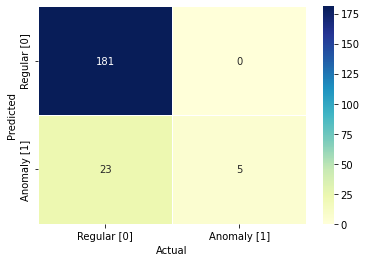

In [106]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    df_pred_test = X_test.copy()
    df_pred_test['Anomaly'] = y_test
    df_pred_test['Pred'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Pred'] = df_pred_test['Pred'].map({1: 0, -1: 1})
    df_pred_test['Outlier_Score'] = model.decision_function(X_test)

    # measure performance
    y_true = df_pred_test['Anomaly']
    x_pred = df_pred_test['Pred'] 
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Regular [0]', 'Anomaly [1]'], 
                yticklabels=['Regular [0]', 'Anomaly [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

model_name = 'Isolation Forest (baseline)'
print(f'{model_name} model')

map_labels = True
model_score = measure_performance(model_isf, X_test, y_test, map_labels)

performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)